In [1323]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import subprocess
import mne
import mne_qt_browser
from scipy.stats import skew, kurtosis

# execute ls, sort files by date created
output = subprocess.run(["ls -t ../data_named"], stdout=subprocess.PIPE, shell=True, text=True)
# show only the last 5 files, line by line
files = output.stdout.split("\n")[:-1][:5]
filename = None
i = 0
print("\n>> Select file to analyze:\n")
for file in files:
    print("  ", i, ":", file)
    i += 1
index = input("\n>> ")
if index == "":
    index = 0 # if no input, default to the most recent file
    filename = files[index]
    print("\nOK, most recent file: ", filename)
else:
    index = int(index)
    filename = files[index]
    print("\nOK, opening: ", filename)


>> Select file to analyze:

   0 : 0225_arjun.npz
   1 : 0210_second.npz
   2 : 0210_first.npz

OK, opening:  0210_first.npz


In [1324]:
import scipy.signal as signal
import scipy.stats as stats

class DataBuilder:
    def __init__(self, sfreq):
        self.sfreq = sfreq

    def load_data(self, data_path):
        # Load the .npz file
        data = np.load(data_path, allow_pickle=True)
        labels = []
        windows = []
        for key in data.files:
            label = data[key].item()['label']
            window = data[key].item()['data']
            labels.append(label)
            windows.append(window)
        # dropping the first window because it's "rest"
        # drop the last window too
        return windows[1:-1], labels[1:-1]
    
    def load_window(self, data_path, index):
        # Load the .npz file
        windows, labels = self.load_data(data_path)
        windows = self.preprocess_data(windows)
        return windows[index], labels[index]

    def preprocess_data(self, windows):
        # remove the first two columns of each window (millis and hall sensor)
        processed_windows = []
        for window in windows:
            window = np.delete(window, [0,1], axis=1)
            processed_windows.append(window)
        
        print("Printing some stats!\n====================")
        print("Number of samples:", len(processed_windows))
        print("Number of channels:", len(processed_windows[0][0]))
        print("====================\n")

        return processed_windows
    
    def create_feature_vector(self, window):
        # window has shape samples x channels
        features = []
        print("Window shape:", window.shape)
        for channel in window.T:
            # extract mean and std
            mean = np.mean(channel)
            std = np.std(channel)

            # demean and normalize
            channel = channel - np.mean(channel)
            channel = channel / np.std(channel)

            # calculate features
            kurtosis = stats.kurtosis(channel)
            skew = stats.skew(channel)
            # find peaks
            peaks, _ = signal.find_peaks(channel)
            num_peaks = len(peaks)
            # find zero crossings
            zero_crossings = np.where(np.diff(np.sign(channel)))[0]
            num_zero_crossings = len(zero_crossings)

            # IEMG
            iemg = np.sum(np.abs(channel))
            # print("IEMG:", iemg)

            # MAV
            mav = np.mean(np.abs(channel))
            # print("MAV:", mav)

            # SSI
            ssi = np.sum(np.square(channel))
            # print("SSI:", ssi)

            # RMS
            rms = np.sqrt(np.mean(np.square(channel)))
            # print("RMS:", rms)

            # VAR
            var = np.var(channel)
            # print("VAR:", var)

            # Myopulse Percentage Rate
            t_mmp = 0.1
            mmp = np.sum(np.abs(channel) > t_mmp) / len(channel)
            # print("MMP:", mmp)

            # Waveform Length
            wl = np.sum(np.abs(np.diff(channel)))
            # print("WL:", wl)

            # DAMV
            damv = np.mean(np.abs(np.diff(channel)))
            # print("DAMV:", damv)

            # M2
            m2 = np.sum(np.square(np.diff(channel)))
            # print("M2:", m2)

            # DVARV
            dvarv = np.mean(np.square(np.diff(channel)))
            # print("DVARV:", dvarv)

            # DASDV
            dasdv = np.sqrt(np.mean(dvarv))
            # print("DASDV:", dasdv)

            # WAMP
            t_wamp = 0.1
            wamp = np.sum(np.abs(np.diff(channel)) > t_wamp)
            # print("WAMP:", wamp)

            # inegerated absolute of second derivative
            iasd = np.sum(np.abs(np.diff(np.diff(channel))))

            # integrated absolute third derivative
            iatd = np.sum(np.abs(np.diff(np.diff(np.diff(channel)))))

            # integerated exponential of absolute value
            # ieav = np.sum(np.exp(np.abs(channel)))
            # print("IEAV:", ieav)

            # integerated absolute log value
            # ialv = np.sum(np.log(np.abs(channel) + 0.1))
            # print("IALV:", ialv)
            # print(np.min(channel))
            # print(np.max(channel))
            # print(np.isnan(channel).any())

            # integrated exponential
            ie = np.sum(np.exp(channel))

            features.append(kurtosis)
            features.append(skew)
            features.append(num_peaks)
            features.append(num_zero_crossings)
            # features.append(mean)
            # features.append(std)
            features.append(iemg)
            # features.append(mav)
            features.append(ssi)
            # features.append(rms)
            # features.append(var)
            features.append(mmp)
            features.append(wl)
            # features.append(damv)
            features.append(m2)
            features.append(dvarv)
            features.append(dasdv)
            features.append(wamp)
            features.append(iasd)
            features.append(iatd)
            # features.append(ieav)
            # features.append(ialv)
            features.append(ie)

        features = np.array(features)
        return features

    def create_feature_matrix(self, windows):
        # windows has shape windows x samples x channels
        feature_matrix = []
        for window in windows:
            feature_vector = self.create_feature_vector(window)
            feature_matrix.append(feature_vector)

        feature_matrix = np.array(feature_matrix)
        print("Feature matrix shape:", feature_matrix.shape)
        return feature_matrix
    
    def get_labels(self):
        return self.labels

    def build_data(self, data_path):
        # Load data
        windows, labels = self.load_data(data_path)
        print("Number of labeled samples:", len(windows))

        # Preprocess data
        windows = self.preprocess_data(windows)

        # Create feature matrix
        X = self.create_feature_matrix(windows)

        # Get labels
        y = labels

        return X, y

In [1325]:
npz_file_path = f"../data_named/{filename}"

data_builder = DataBuilder(sfreq=1000)
X, y = data_builder.build_data(data_path=npz_file_path)

window_4, label_4 = data_builder.load_window(npz_file_path, 4)

print("X shape:", X.shape)
print("y shape:", len(y))

Number of labeled samples: 61
Printing some stats!
Number of samples: 61
Number of channels: 5

Window shape: (667, 5)
Window shape: (798, 5)
Window shape: (908, 5)
Window shape: (759, 5)
Window shape: (575, 5)
Window shape: (826, 5)
Window shape: (748, 5)
Window shape: (634, 5)
Window shape: (540, 5)
Window shape: (781, 5)
Window shape: (712, 5)
Window shape: (954, 5)
Window shape: (717, 5)
Window shape: (887, 5)
Window shape: (723, 5)
Window shape: (788, 5)
Window shape: (518, 5)
Window shape: (707, 5)
Window shape: (1011, 5)
Window shape: (719, 5)
Window shape: (659, 5)
Window shape: (875, 5)
Window shape: (555, 5)
Window shape: (744, 5)
Window shape: (995, 5)
Window shape: (650, 5)
Window shape: (912, 5)
Window shape: (990, 5)
Window shape: (603, 5)
Window shape: (751, 5)
Window shape: (569, 5)
Window shape: (536, 5)
Window shape: (1021, 5)
Window shape: (947, 5)
Window shape: (873, 5)
Window shape: (710, 5)
Window shape: (564, 5)
Window shape: (730, 5)
Window shape: (862, 5)
Windo

/var/folders/js/fb9kwys10ln8jgq1bxxqg0tr0000gn/T/ipykernel_31015/3809396452.py:53: RuntimeWarning: invalid value encountered in divide
  channel = channel / np.std(channel)
/var/folders/js/fb9kwys10ln8jgq1bxxqg0tr0000gn/T/ipykernel_31015/3809396452.py:53: RuntimeWarning: divide by zero encountered in divide
  channel = channel / np.std(channel)


In [1326]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# linear classifier
from sklearn.linear_model import LogisticRegression

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
# drop nans in X_test
y_test = np.array(y_test)
y_test = y_test[~np.isnan(X_test).any(axis=1)]
X_test = X_test[~np.isnan(X_test).any(axis=1)]
y_train = np.array(y_train)
y_train = y_train[~np.isnan(X_train).any(axis=1)]
X_train = X_train[~np.isnan(X_train).any(axis=1)]

model = LogisticRegression()
model.fit(X_train, y_train)

/Users/bei/anaconda3/envs/ntb/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [1327]:
# # save model
# import pickle
# pickle.dump(model, open("model.pkl", "wb"))

# # load model
# model = pickle.load(open("model.pkl", "rb"))

In [1328]:
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Additional metrics
print(classification_report(y_test, y_pred))

Accuracy: 0.48
                 precision    recall  f1-score   support

     double-tap       0.60      0.75      0.67         4
           rest       0.33      0.40      0.36         5
            tap       0.67      0.33      0.44         6
 thumb-to-index       0.25      0.50      0.33         2
thumb-to-middle       0.00      0.00      0.00         1
 thumb-to-pinky       1.00      0.50      0.67         2
  thumb-to-ring       1.00      1.00      1.00         1

       accuracy                           0.48        21
      macro avg       0.55      0.50      0.50        21
   weighted avg       0.55      0.48      0.48        21



In [1329]:
def run_inference(window, model):
    feature_vector = data_builder.create_feature_vector(window)
    feature_vector = np.array([feature_vector])
    print("Feature vector shape:", feature_vector.shape)
    prediction = model.predict(feature_vector)
    return prediction

prediction = run_inference(window_4, model)
print("Prediction:", prediction)
print("Actual:", label_4)

Window shape: (575, 5)
Feature vector shape: (1, 75)
Prediction: ['thumb-to-middle']
Actual: double-tap


## QDA

In [1330]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
qda = QuadraticDiscriminantAnalysis(tol=1e-1)
qda.fit(X_train, y_train)
y_pred = qda.predict(X_test)

/Users/bei/anaconda3/envs/ntb/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


In [1331]:
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

                 precision    recall  f1-score   support

     double-tap       0.00      0.00      0.00         4
           rest       0.00      0.00      0.00         5
            tap       0.00      0.00      0.00         6
 thumb-to-index       0.00      0.00      0.00         2
thumb-to-middle       0.00      0.00      0.00         1
 thumb-to-pinky       0.00      0.00      0.00         2
  thumb-to-ring       0.05      1.00      0.10         1

       accuracy                           0.05        21
      macro avg       0.01      0.14      0.01        21
   weighted avg       0.00      0.05      0.00        21

Accuracy: 0.047619047619047616


/Users/bei/anaconda3/envs/ntb/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/bei/anaconda3/envs/ntb/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/bei/anaconda3/envs/ntb/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### LDA

In [1332]:
X_train

array([[1.22915698e+01, 3.36131018e+00, 3.81000000e+02, ...,
        1.16278368e+02, 2.19105678e+02, 1.19959979e+03],
       [5.40031015e-02, 1.26585883e+00, 2.53000000e+02, ...,
        1.33516804e+01, 2.14848767e+01, 1.02915391e+03],
       [1.06035110e+01, 3.13738678e+00, 4.21000000e+02, ...,
        3.31638131e+02, 6.29533591e+02, 1.23923170e+03],
       ...,
       [2.40963477e+00, 1.85351370e+00, 2.10000000e+02, ...,
        2.75224403e+02, 4.94240084e+02, 1.45970181e+03],
       [1.95421902e+01, 4.12082417e+00, 3.85000000e+02, ...,
        2.41191705e+02, 4.72315517e+02, 9.55941172e+02],
       [8.26536225e+00, 2.78756524e+00, 3.58000000e+02, ...,
        2.10139934e+02, 4.02144584e+02, 1.34298154e+03]])

In [1333]:
# lda
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis(solver='lsqr')
lda.fit(X_train, y_train)
y_pred = lda.predict(X_test)

In [1334]:
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

                 precision    recall  f1-score   support

     double-tap       1.00      0.75      0.86         4
           rest       0.57      0.80      0.67         5
            tap       1.00      0.33      0.50         6
 thumb-to-index       0.50      1.00      0.67         2
thumb-to-middle       0.00      0.00      0.00         1
 thumb-to-pinky       0.50      0.50      0.50         2
  thumb-to-ring       1.00      1.00      1.00         1

       accuracy                           0.62        21
      macro avg       0.65      0.63      0.60        21
   weighted avg       0.76      0.62      0.62        21

Accuracy: 0.6190476190476191


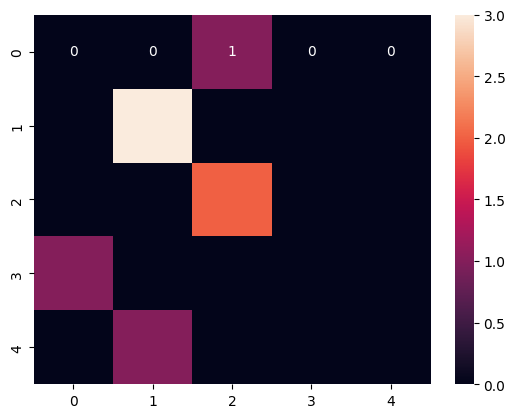

In [1351]:
# confusion matrix for y_test and y_pred
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.show()

In [1350]:
y_pred

array(['tap', 'tap', 'thumb-to-index', 'double-tap', 'tap',
       'thumb-to-index', 'tap', 'thumb-to-index'], dtype='<U15')

In [1352]:
y_test

array(['thumb-to-ring', 'tap', 'thumb-to-index', 'thumb-to-middle', 'tap',
       'thumb-to-index', 'tap', 'double-tap'], dtype='<U15')

### Remap to classify only thumb-related movements and tap-related movements

In [1335]:
y_remap = np.array(y)
y_remap

array(['thumb-to-index', 'thumb-to-middle', 'thumb-to-ring',
       'thumb-to-pinky', 'double-tap', 'tap', 'rest', 'thumb-to-index',
       'thumb-to-middle', 'thumb-to-ring', 'thumb-to-pinky', 'double-tap',
       'tap', 'rest', 'thumb-to-index', 'thumb-to-middle',
       'thumb-to-ring', 'thumb-to-pinky', 'double-tap', 'tap', 'rest',
       'thumb-to-index', 'thumb-to-middle', 'thumb-to-ring',
       'thumb-to-pinky', 'double-tap', 'tap', 'rest', 'thumb-to-index',
       'thumb-to-middle', 'thumb-to-ring', 'thumb-to-pinky', 'double-tap',
       'tap', 'rest', 'thumb-to-index', 'thumb-to-middle',
       'thumb-to-ring', 'thumb-to-pinky', 'double-tap', 'tap', 'rest',
       'thumb-to-index', 'thumb-to-middle', 'thumb-to-ring',
       'thumb-to-pinky', 'double-tap', 'tap', 'rest', 'thumb-to-index',
       'thumb-to-middle', 'thumb-to-ring', 'thumb-to-pinky', 'double-tap',
       'tap', 'rest', 'thumb-to-index', 'thumb-to-middle',
       'thumb-to-ring', 'thumb-to-pinky', 'double-tap'], 

In [1336]:
# y_remap = []
# for label in y:
#     if label == "thumb-to-index" or label == "thumb-to-middle" or label == "thumb-to-ring" or label == "thumb-to-pinky":
#         y_remap.append("thumb")
#     if label == "tap" or label == "double-tap":
#         y_remap.append("tapping")
#     if label == "rest":
#         y_remap.append("rest")
# y_remap = np.array(y_remap)
# y_remap

In [1337]:
y_remap != "rest"

array([ True,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True, False,  True,  True,  True,  True,  True,  True,
       False,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True,  True,
        True, False,  True,  True,  True,  True,  True])

In [1338]:
idx = (y_remap != "rest") * (y_remap != "thumb-to-pinky")
X_remap = X[idx]
y_remap = y_remap[idx]

In [1339]:
X_remap.shape

(44, 75)

In [1340]:
y_remap.shape

(44,)

In [1341]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# linear classifier
from sklearn.linear_model import LogisticRegression

X_train, X_test, y_train, y_test = train_test_split(X_remap, y_remap, test_size=0.2, random_state=42)
# drop nans in X_test
y_test = np.array(y_test)
y_test = y_test[~np.isnan(X_test).any(axis=1)]
X_test = X_test[~np.isnan(X_test).any(axis=1)]
y_train = np.array(y_train)
y_train = y_train[~np.isnan(X_train).any(axis=1)]
X_train = X_train[~np.isnan(X_train).any(axis=1)]

model = LogisticRegression()
model.fit(X_train, y_train)

/Users/bei/anaconda3/envs/ntb/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [1342]:
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Additional metrics
print(classification_report(y_test, y_pred))

Accuracy: 0.75
                 precision    recall  f1-score   support

     double-tap       0.50      1.00      0.67         1
            tap       1.00      1.00      1.00         3
 thumb-to-index       1.00      0.50      0.67         2
thumb-to-middle       0.00      0.00      0.00         1
  thumb-to-ring       0.50      1.00      0.67         1

       accuracy                           0.75         8
      macro avg       0.60      0.70      0.60         8
   weighted avg       0.75      0.75      0.71         8



/Users/bei/anaconda3/envs/ntb/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/bei/anaconda3/envs/ntb/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/bei/anaconda3/envs/ntb/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [1343]:
y_pred

array(['thumb-to-ring', 'tap', 'thumb-to-index', 'thumb-to-ring', 'tap',
       'double-tap', 'tap', 'double-tap'], dtype='<U15')

In [1344]:
y_test

array(['thumb-to-ring', 'tap', 'thumb-to-index', 'thumb-to-middle', 'tap',
       'thumb-to-index', 'tap', 'double-tap'], dtype='<U15')

In [1345]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

In [1346]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [1347]:
svm = SVC(kernel='linear', random_state=42)
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)

In [1348]:
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

                 precision    recall  f1-score   support

     double-tap       0.00      0.00      0.00         1
            tap       0.75      1.00      0.86         3
 thumb-to-index       0.67      1.00      0.80         2
thumb-to-middle       0.00      0.00      0.00         1
  thumb-to-ring       0.00      0.00      0.00         1

       accuracy                           0.62         8
      macro avg       0.28      0.40      0.33         8
   weighted avg       0.45      0.62      0.52         8

Accuracy: 0.625


/Users/bei/anaconda3/envs/ntb/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/bei/anaconda3/envs/ntb/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/bei/anaconda3/envs/ntb/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
